In [65]:
'''
Aerosol/AA paper figure
author: You-Ting Wu @ NTU
'''
from ast import mod
from fileinput import filename
import re
from turtle import title
import numpy as np
import xarray as xr
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
import imageio
import glob
from scipy.stats import norm
import statsmodels.api as sm

In [66]:
# initial data setting
lat_arctic = 70 

lat_tropics = [-90,90]
year_interval = [[1955,1984],[1976, 2005], [1955, 2005]]
year_interval_str = ['1955','1976','2005']
month_abbr = ['Jan.','Feb.','Mar.','Apr.','May.','Jun.','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.']
start_month = 6
month_abbr_shift = month_abbr[start_month-1:] + month_abbr[0:start_month-1]
alph = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)',]
blue = sns.color_palette("Blues", 15)
red = sns.color_palette("Reds", 15)
color_aer = [blue[4], blue[11], blue[-1]]
color_ghg = [red[4], red[11], red[-1]]

In [92]:
################################################## fx.s ##################################################

def linear_trend(data, year_interval):
    
    data_trend = data.sel(year=slice(year_interval[0],year_interval[1])).polyfit(dim = 'year', deg = 1)['polyfit_coefficients'][0]

    return(data_trend)

def merge_data(case, var):
    # define agent names
    if case == 'cesm1_fix1920_60N_masked' or case == 'cesm1_fix1920_70N_masked':
        agent_name = ['ALL', 'xAER', 'xGHG']
        
        # read all data
        data_tmp = []
        file_all = sorted(glob.glob(case+'/'+var+'*.nc'))
        for i in range(len(file_all)):
            data_tmp.append(xr.open_dataarray(file_all[i]))
    else:
        agent_name = ['ALL', 'xAER', 'xC2']

        # read all data
        file_all = sorted(glob.glob(case+'/'+var+'*.nc'))

        data_tmp = xr.open_dataarray(file_all[0]).transpose('agent',...)

    # merge data        
    if var == 'ICEFRAC' or var == 'siconc':
        data_agent = {agent_name[i]: data_tmp[i]/1e12 for i in range(len(agent_name))}
    else:
        data_agent = {agent_name[i]: data_tmp[i] for i in range(len(agent_name))}

    return(data_agent)

def temp_anomaly(data, year_ref):

    data_tmp = data.mean('month')

    data_anom = data_tmp - data_tmp.sel(year=slice(year_ref[0], year_ref[1])).mean('year')

    return(data_anom)

def agent_linear_trend(data, year_interval, area, month, **kwargs):
    
    str_annual = 'JFMAMJJASOND'

    # do linear trend in each agent for given dictionary
    data_trend = {}
    for agent, data_agent in data.items():

        if 'cesm1_fix1955' in kwargs and agent == 'xC2':
            data_agent = data_agent.isel(ensemble = slice(0,10))

        # 12 months
        if month == 'none':
            tmp = xr.concat([linear_trend(data_agent.sel(area = area), year_interval[i]) for i in range(len(year_interval))],\
                            pd.Index(year_interval_str, name='period')).transpose('ensemble', 'period',...)

        # seasonal or annual
        else:
            idx = (str_annual*2).find(month)
            m = [np.mod(idx+i,12)+1 for i in range(len(month))]
            
            tmp = xr.concat([linear_trend(data_agent.sel(area = area, month = m).mean('month'), year_interval[i]) for i in range(len(year_interval))],\
                            pd.Index(year_interval_str, name='period')).transpose('ensemble', 'period',...)
        
        if month != 'none':
            if month == str_annual:
                tmp.attrs['season'] = 'annual'
            else:
                tmp.attrs['season'] = month

        data_trend[agent] = tmp

    return(data_trend)

def resampling_ratio(var, dts, **kwargs):
    
    random = np.array(np.random.choice(dts['ALL']['ensemble'].size, [N,dts['ALL']['ensemble'].size]), dtype=np.intp)

    # do resampling for given variable and ts
    data_rsp = {}
    for agent, data_agent in var.items():

        if 'cesm1_fix1920' in kwargs or 'cesm1_fix1955' in kwargs:
            if agent != 'ALL':
                random = np.array(np.random.choice(dts[agent]['ensemble'].size, [N,dts[agent]['ensemble'].size]), dtype=np.intp)

        var_rsp = data_agent.values[random,...].mean(1)
        ts_rsp =  dts[agent].values[random,...].mean(1)

        if len(data_agent.dims) == 3:
            index = ["rsp", "period", "month"]
            coords = {
                "rsp": np.arange(N),
                "period": year_interval_str,
                "month": dts['ALL']['month'].values
            }
        elif len(data_agent.dims) == 2:
            index = ["rsp", "period"]
            coords = {
                "rsp": np.arange(N),
                "period": year_interval_str,
            }
        
        # create dataset
        ds = xr.Dataset(
            {
                "variable": (index, var_rsp),
                "tas_global": (index, ts_rsp),
            },
            coords = coords
        )

        data_rsp[agent] = ds

    return(data_rsp)

In [68]:
################################## read files ##################################
#---------------------------------- CESM1-fix1955 ----------------------------------#
# case = 'cesm1_fix1955_60N_masked'
case = 'cesm1_fix1955_70N_masked'
ts_cesm1955 = merge_data(case, 'TS')
sia_cesm1955 = merge_data(case, 'ICEFRAC')
fsns = merge_data(case, 'FSNS') # net shortwave flux at surface
fsds = merge_data(case, 'FSDS') # downwelling shortwave flux at surface
lhflx = merge_data(case, 'LHFLX') # latent heat flux
shflx = merge_data(case, 'SHFLX') # sensible heat flux

thf_cesm1955 = {k: lhflx.get(k, 0) + shflx.get(k, 0) for k in set(lhflx) | set(shflx)} # net surface heat flux (positive upward)
alb_cesm1955 = {k: (1 - fsns.get(k, 0) / fsds.get(k, 0)) * 100 for k in set(fsns) | set(fsds)} # albedo (%)


#---------------------------------- CanESM5-fix1955 ----------------------------------#
# case = 'canesm5_fix1955_60N_masked'
case = 'canesm5_fix1955_70N_masked'
ts_can1955 = merge_data(case, 'tas')
sia_can1955 = merge_data(case, 'siconc')
rsds = merge_data(case, 'rsds')
rsus = merge_data(case, 'rsus')
hfss = merge_data(case, 'hfss')
hfls = merge_data(case, 'hfls')

thf_can1955 = {k: hfss.get(k, 0) + hfls.get(k, 0) for k in set(hfss) | set(hfls)} # net surface heat flux (positive upward)
alb_can1955 = {k: (rsus.get(k, 0) / rsds.get(k, 0)) * 100 for k in set(rsus) | set(rsds)} # albedo (%)


#---------------------------------- CESM1-fix1920 ----------------------------------#
# case = 'cesm1_fix1920_60N_masked'
case = 'cesm1_fix1920_70N_masked'
ts_cesm1920 = merge_data(case, 'TREFHT')
sia_cesm1920 = merge_data(case, 'ICEFRAC')
fsns = merge_data(case, 'FSNS') # net shortwave flux at surface
fsds = merge_data(case, 'FSDS') # downwelling shortwave flux at surface
hfss = merge_data(case, 'SHFLX') # sensible heat flux
hfls = merge_data(case, 'LHFLX') # latent heat flux

thf_cesm1920 = {k: hfss.get(k, 0) + hfls.get(k, 0) for k in set(hfss) | set(hfls)} # net surface heat flux (positive upward)
alb_cesm1920 = {k: (1 - fsns.get(k, 0) / fsds.get(k, 0)) * 100 for k in set(fsns) | set(fsds)} # albedo (%)

In [89]:
################################## calculate trends for all months ##################################
#---------------------------------- CESM1-fix1955 ----------------------------------#
sia_month_cesm1955 = agent_linear_trend(sia_cesm1955, year_interval, 'arctic', month='none', cesm1_fix1955 = True)
alb_month_cesm1955 = agent_linear_trend(alb_cesm1955, year_interval, 'arctic', month='none', cesm1_fix1955 = True)
thf_month_cesm1955 = agent_linear_trend(thf_cesm1955, year_interval, 'arctic', month='none', cesm1_fix1955 = True)
ta_month_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'arctic', month='none', cesm1_fix1955 = True)
tg_month_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'tropics', month='none', cesm1_fix1955 = True)


#---------------------------------- CanESM5-fix1955 ----------------------------------#
sia_month_can1955 = agent_linear_trend(sia_can1955, year_interval, 'arctic', month='none')
alb_month_can1955 = agent_linear_trend(alb_can1955, year_interval, 'arctic', month='none')
thf_month_can1955 = agent_linear_trend(thf_can1955, year_interval, 'arctic', month='none')
ta_month_can1955 = agent_linear_trend(ts_can1955, year_interval, 'arctic', month='none')
tg_month_can1955 = agent_linear_trend(ts_can1955, year_interval, 'tropics', month='none')


#---------------------------------- CESM1-fix1920 ----------------------------------#
sia_month_cesm1920 = agent_linear_trend(sia_cesm1920, year_interval, 'arctic', month='none')
alb_month_cesm1920 = agent_linear_trend(alb_cesm1920, year_interval, 'arctic', month='none')
thf_month_cesm1920 = agent_linear_trend(thf_cesm1920, year_interval, 'arctic', month='none')
ta_month_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'arctic', month='none')
tg_month_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'tropics', month='none')



################################## calculate trends for seasonal/annual means ##################################
warm = 'JAS'
cold = 'OND'
annual = 'JFMAMJJASOND'
#---------------------------------- CESM1-fix1955 ----------------------------------#
ta_ann_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'arctic', month=annual, cesm1_fix1955 = True)
tg_ann_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'tropics', month=annual, cesm1_fix1955 = True)
tg_cold_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'tropics', month=cold, cesm1_fix1955 = True)
tg_warm_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'tropics', month=warm, cesm1_fix1955 = True)

sia_ann_cesm1955 = agent_linear_trend(sia_cesm1955, year_interval, 'arctic', month=annual, cesm1_fix1955 = True)
thf_cold_cesm1955 = agent_linear_trend(thf_cesm1955, year_interval, 'arctic', month=cold, cesm1_fix1955 = True)
alb_warm_cesm1955 = agent_linear_trend(alb_cesm1955, year_interval, 'arctic', month=warm, cesm1_fix1955 = True)   


#---------------------------------- CanESM5-fix1955 ----------------------------------#
ta_ann_can1955 = agent_linear_trend(ts_can1955, year_interval, 'arctic', month=annual)
tg_ann_can1955 = agent_linear_trend(ts_can1955, year_interval, 'tropics', month=annual)
tg_cold_can1955 = agent_linear_trend(ts_can1955, year_interval, 'tropics', month=cold)
tg_warm_can1955 = agent_linear_trend(ts_can1955, year_interval, 'tropics', month=warm)

sia_ann_can1955 = agent_linear_trend(sia_can1955, year_interval, 'arctic', month=annual)
thf_cold_can1955 = agent_linear_trend(thf_can1955, year_interval, 'arctic', month=cold)
alb_warm_can1955 = agent_linear_trend(alb_can1955, year_interval, 'arctic', month=warm)  


#---------------------------------- CESM1-fix1920 ----------------------------------#
ta_ann_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'arctic', month=annual)
tg_ann_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'tropics', month=annual)
tg_cold_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'tropics', month=cold)
tg_warm_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'tropics', month=warm)

sia_ann_cesm1920 = agent_linear_trend(sia_cesm1920, year_interval, 'arctic', month=annual)
thf_cold_cesm1920 = agent_linear_trend(thf_cesm1920, year_interval, 'arctic', month=cold)
alb_warm_cesm1920 = agent_linear_trend(alb_cesm1920, year_interval, 'arctic', month=warm)

In [93]:
################################## resampling ##################################
N = 10000

#---------------------------------- CESM1-fix1955 ----------------------------------#
msia_cesm1955 = resampling_ratio(sia_month_cesm1955, tg_month_cesm1955, cesm1_fix1955 = True)
malb_cesm1955 = resampling_ratio(alb_month_cesm1955, tg_month_cesm1955, cesm1_fix1955 = True)
mthf_cesm1955 = resampling_ratio(thf_month_cesm1955, tg_month_cesm1955, cesm1_fix1955 = True)
maaf_cesm1955 = resampling_ratio(ta_month_cesm1955, tg_month_cesm1955, cesm1_fix1955 = True)

aaaf_cesm1955 = resampling_ratio(ta_ann_cesm1955, tg_ann_cesm1955, cesm1_fix1955 = True)
asia_cesm1955 = resampling_ratio(sia_ann_cesm1955, tg_ann_cesm1955, cesm1_fix1955 = True)
walb_cesm1955 = resampling_ratio(alb_warm_cesm1955, tg_warm_cesm1955, cesm1_fix1955 = True)
cthf_cesm1955 = resampling_ratio(thf_cold_cesm1955, tg_cold_cesm1955, cesm1_fix1955 = True)


#---------------------------------- CanESM5-fix1955 ----------------------------------#
msia_can1955 = resampling_ratio(sia_month_can1955, tg_month_can1955)
malb_can1955 = resampling_ratio(alb_month_can1955, tg_month_can1955)
mthf_can1955 = resampling_ratio(thf_month_can1955, tg_month_can1955)
maaf_can1955 = resampling_ratio(ta_month_can1955, tg_month_can1955)

aaaf_can1955 = resampling_ratio(ta_ann_can1955, tg_ann_can1955)
asia_can1955 = resampling_ratio(sia_ann_can1955, tg_ann_can1955)
walb_can1955 = resampling_ratio(alb_warm_can1955, tg_warm_can1955)
cthf_can1955 = resampling_ratio(thf_cold_can1955, tg_cold_can1955)


#---------------------------------- CESM1-fix1920 ----------------------------------#
msia_cesm1920 = resampling_ratio(sia_month_cesm1920, tg_month_cesm1920, cesm1_fix1920=True)
malb_cesm1920 = resampling_ratio(alb_month_cesm1920, tg_month_cesm1920, cesm1_fix1920=True)
mthf_cesm1920 = resampling_ratio(thf_month_cesm1920, tg_month_cesm1920, cesm1_fix1920=True)
maaf_cesm1920 = resampling_ratio(ta_month_cesm1920, tg_month_cesm1920, cesm1_fix1920=True)

aaaf_cesm1920 = resampling_ratio(ta_ann_cesm1920, tg_ann_cesm1920, cesm1_fix1920=True)
asia_cesm1920 = resampling_ratio(sia_ann_cesm1920, tg_ann_cesm1920, cesm1_fix1920=True)
walb_cesm1920 = resampling_ratio(alb_warm_cesm1920, tg_warm_cesm1920, cesm1_fix1920=True)
cthf_cesm1920 = resampling_ratio(thf_cold_cesm1920, tg_cold_cesm1920, cesm1_fix1920=True)

In [94]:
ta_ann_cesm1955['xC2']

<xarray.DataArray 'polyfit_coefficients' (ensemble: 10, period: 3)>
array([[ 0.02589021, -0.00859369,  0.01099471],
       [ 0.00367812, -0.0141556 ,  0.00340531],
       [-0.01798228,  0.03617069,  0.01083151],
       [ 0.04997575, -0.01071599,  0.01910555],
       [ 0.0259151 , -0.03387362,  0.00079028],
       [ 0.00219795, -0.02591602, -0.00292292],
       [ 0.01003705,  0.01236077,  0.00663969],
       [-0.00135618,  0.01464387,  0.00482698],
       [ 0.02212697,  0.00210887,  0.01105867],
       [ 0.01273462,  0.02060077,  0.02081759]])
Coordinates:
    degree    int64 1
  * ensemble  (ensemble) object '000' '001' '002' '003' ... '007' '008' '009'
  * period    (period) object '1955' '1976' '2005'
Attributes:
    season:   annual

In [99]:
[ print('CESM1-fix1920\n',k,\
    ': arctic', v['variable'].sel(period = '1976').mean('rsp').values,\
     'global', v['tas_global'].sel(period = '1976').mean('rsp').values,\
        'AAF', (v['variable'].sel(period = '1976').mean('rsp').values)/(v['tas_global'].sel(period = '1976').mean('rsp').values)) for k, v  in aaaf_cesm1920.items()]

[ print('CESM1-fix1955\n',k,\
    ': arctic', v['variable'].sel(period = '1976').mean('rsp').values,\
     'global', v['tas_global'].sel(period = '1976').mean('rsp').values,\
        'AAF', (v['variable'].sel(period = '1976').mean('rsp').values)/(v['tas_global'].sel(period = '1976').mean('rsp').values)) for k, v  in aaaf_cesm1955.items()]

[ print('CanESM5-fix1955\n',k,\
    ': arctic', v['variable'].sel(period = '1976').mean('rsp').values,\
     'global', v['tas_global'].sel(period = '1976').mean('rsp').values,\
        'AAF', (v['variable'].sel(period = '1976').mean('rsp').values)/(v['tas_global'].sel(period = '1976').mean('rsp').values)) for k, v  in aaaf_can1955.items()]

CESM1-fix1920
 ALL : arctic 0.05151907946348746 global 0.016220543276430244 AAF 3.1761623877511447
CESM1-fix1920
 xAER : arctic 0.02847741815809128 global 0.01418254549187852 AAF 2.007920099702734
CESM1-fix1920
 xGHG : arctic -0.01927562857509127 global -0.005972776470208159 AAF 3.22724760774774
CESM1-fix1955
 ALL : arctic 0.055381260045803536 global 0.01547381643698063 AAF 3.579030439668958
CESM1-fix1955
 xAER : arctic 0.03908894651736431 global 0.015380052662795496 AAF 2.5415352843310393
CESM1-fix1955
 xC2 : arctic -0.000890395097738118 global 0.0005899752142917304 AAF -1.509207634776732
CanESM5-fix1955
 ALL : arctic 0.10128590025459776 global 0.03467797134315097 AAF 2.9207562129957787
CanESM5-fix1955
 xAER : arctic 0.11153339381284777 global 0.035964353775879275 AAF 3.101220572678591
CanESM5-fix1955
 xC2 : arctic 0.03603306266305606 global 0.014738899023132248 AAF 2.4447594495696916


[None, None, None]

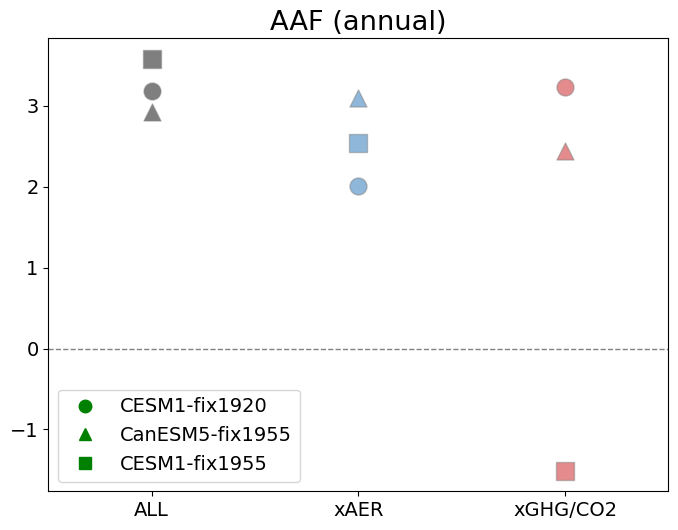

In [101]:
################################## figure 2 ##################################
# plot 3 panels of scatter plot, each panel is for one variables
title = 'AAF (annual)'
model = ['CESM1-fix1920', 'CanESM5-fix1955', 'CESM1-fix1955']
variable = [aaaf_cesm1920, aaaf_can1955, aaaf_cesm1955]
period = '1976'
variable_unit = ''
fontsize = 14
color = ['k', color_aer[1], color_ghg[1]]
color_mean = [color_aer[2], color_ghg[2], sns.color_palette("YlOrBr", 10)[4]]
color_diff = '#FFE171'
markers = ['o', '^', 's']

# add legend outside the plot
# num = [10,30,10,10]
# numc = [20,10,20]
# legend = []
# for i in range(2):
#     for j in range(3):
#         if i ==0 and j == 1:
#             legend.append(mlines.Line2D([], [], color = colorc[i], marker = markersc[j], markersize=9, label='%s (%s)'%(legend_namec[j][i], 20), linestyle = 'None'))
#         else:
#             legend.append(mlines.Line2D([], [], color = colorc[i], marker = markersc[j], markersize=9, label='%s (%s)'%(legend_namec[j][i], numc[j]), linestyle = 'None'))
#     for j in range(4):
#         legend.append(mlines.Line2D([], [], color = color[i], marker = markers[j], markersize=9, label='%s (%s)'%(legend_name[j][i], num[j]), linestyle = 'None'))
# legend.append(mpatches.Patch(color= color_diff, label='AER $-$ GHG/CO2'))
# legend.append(mlines.Line2D([], [], color = 'grey', marker = 'H', markersize=12, label='Multi-model Mean', linestyle = 'None'))

fig = plt.figure(figsize=(8,6), dpi = 100)
ax = fig.add_subplot(1,1,1)

mean_aer = []
mean_ghg = []
for i in range(3): # model

    if model[i] == 'CESM1-fix1920':
        agent = ['ALL', 'xAER', 'xGHG']
    else:
        agent = ['ALL', 'xAER', 'xC2']

    for j in range(3): # agent
        ax.scatter([j], variable[i][agent[j]]['variable'].sel(period = period).mean('rsp')/variable[i][agent[j]]['tas_global'].sel(period = period).mean('rsp'),\
                s = 150, color = color[j], alpha = 0.5, marker = markers[i], edgecolor='grey')
    
    # mean_aer.append((variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0])/variablec[j-4][i]['tas_global'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0])).values)
    # mean_ghg.append((variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])/variablec[j-4][i]['tas_global'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])).values)
        
        
    # diff = (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0]) - \
    #         (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])
    # ax.scatter([2], [diff], s = 150, color = color_diff, alpha = 1, marker = markersc[j-4], edgecolor='grey')

# # add mean
# ax.scatter([0,1,2], [np.mean(mean_aer), np.mean(mean_ghg), np.mean(mean_aer)-np.mean(mean_ghg)], s = 600, color = color_mean, alpha = 1, marker = 'H', edgecolor='grey', linewidths=1, zorder = -100)


# axis setting
ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['ALL', 'xAER','xGHG/CO2'], fontsize = fontsize)
ax.set_ylabel(variable_unit, fontsize = fontsize)
ax.set_title(title, fontsize = fontsize*1.4)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
# add horizontal line
ax.axhline(y=0, color='grey', linestyle='--', linewidth = 1)
# ax.set_ylim([1.4,5.])

# add legend for markers
legend = []
for i in range(3):
    legend.append(mlines.Line2D([], [], color = 'green', marker = markers[i], markersize=9, label=model[i], linestyle = 'None'))
ax.legend(handles = legend,loc='lower left',fontsize = fontsize, ncol=1)



In [73]:
# calculate temperature anomaly for each dataset
ts_cesm1920_anom = {k: temp_anomaly(v, [1920, 1920]) for k, v in ts_cesm1920.items()}
ts_cesm1955_anom = {k: temp_anomaly(v, [1955, 1955]) for k, v in ts_cesm1955.items()}
ts_can1955_anom = {k: temp_anomaly(v, [1955, 1955]) for k, v in ts_can1955.items()}

In [74]:
# plot time series
case = 'CanESM5-fix1955' # CESM1-fix1920, CanESM5-fix1955, CESM1-fix1955, 
fontsize = 14
# ylim = [[-4, 4],[-1.5,1.5]]
color = ['black', color_aer[1], color_ghg[1]]
title = ['(a) Arctic Temperature', '(b) Global Temperature']
ylabel = ['[$K$]', '[$K$]']

if case == 'CESM1-fix1920':
    ts = ts_cesm1920_anom
    agent = ['ALL','xAER','xGHG']
    marker = 'o'
elif case == 'CanESM5-fix1955':
    ts = ts_can1955_anom
    agent = ['ALL','xAER','xC2']
    marker = '^'
elif case == 'CESM1-fix1955':
    ts = ts_cesm1955_anom
    agent = ['ALL','xAER','xC2']
    marker = 's'


# plot time series
fig, ax = plt.subplots(2,1, figsize=(7, 10), facecolor='w', dpi = 100)
plt.subplots_adjust(hspace = 0.3)

# plot temperature anomal y
for i in range(2): # area
    for j in range(3): # agent
        ax[i].plot(ts[agent[j]]['year'], ts[agent[j]].mean('ensemble').isel(area = i), color = color[j], marker=marker, markersize=6, linewidth=2, markevery = 3, alpha = 0.7)

        # ensemble spread (+- 1 std)
        ax[i].fill_between(ts[agent[j]]['year'], ts[agent[j]].mean('ensemble').isel(area = i) - ts[agent[j]].std('ensemble').isel(area = i), ts[agent[j]].mean('ensemble').isel(area = i) + ts[agent[j]].std('ensemble').isel(area = i), color = color[j], alpha = 0.2)

    ax[i].axhline(y=0, color='grey', linestyle='-', linewidth=2, alpha = 1)
    ax[i].set_ylabel(ylabel[i], fontsize=fontsize)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i].set_title(title[i], fontsize=fontsize*1.2)

    # fill the color between 1955-1984
    ax[i].axvspan(1955,1984, alpha=0.15, color='yellow', zorder = -1)

# legend
legend_elements = [mlines.Line2D([0], [0], color=color[i], marker=marker, markersize=6, linewidth=2, label=agent[i]) for i in range(3)]
ax[0].legend(handles=legend_elements, loc='upper left', fontsize=fontsize*0.8)